参考：

[1] CIFAR-10 and CIFAR-100 datasets

(<http://www.cs.toronto.edu/~kriz/cifar.html>)

[2] Kaggle Kernel: CNN Architectures : VGG, ResNet, Inception + TL

(<https://www.kaggle.com/shivamb/cnn-architectures-vgg-resnet-inception-tl>)

[3] cifar10とKerasを使ってCNN(Convolutional Neural Network)を実装してみる

(<https://qiita.com/God_KonaBanana/items/10fa8bb58cdd1dbd2e59>)

[4] DeepLearning：VGG16をkerasで実装した

(<http://blog.neko-ni-naritai.com/entry/2018/04/07/115504>)


# 1.0 Introduction

① データセットとして何を選んだか：CIFAR-10

② 実装面で注意が必要だった点を該当箇所の近辺に：随所に記載

③ 日々の作業の進捗を、末尾に、変更履歴のような形で(他のメンバが参照する際に、前回参照時からの差分をすぐに理解できるように)：
20191223: 初版



## 1.1 ライブラリをインポート

In [0]:
# 各種ライブラリをインポートする。
%tensorflow_version 1.x
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# 2.0 Data preparation



## 2.1 Load data

In [0]:
# CIFAR-10のデータセットをロードする。
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

## 2.1.1 Check data

In [0]:
# 画像データの次元を確認する。
print("x_train:")
print("Dimension:", x_train.ndim)
print("Size:", x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3])
print("y_train:")
print("Dimension:", y_train.ndim)
print("Size:", y_train.shape[0], y_train.shape[1])
print("")
print("x_test:")
print("Dimension:", x_test.ndim)
print("Size:", x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3])
print("y_test:")
print("Dimension:", y_test.ndim)
print("Size:", y_test.shape[0], y_test.shape[1])

In [0]:
# 簡単に画像データを確認する。
# 確認する画像の番号tmp_iを指定する。
tmp_i = 2
# データを確認する。
print(tmp_i, "番目の画像の先頭の1ピクセルのRGB値:", x_train[tmp_i][0][0])
print(tmp_i, "番目の画像の正解ラベル値:", y_train[tmp_i])
# 画像を表示する。
plt.figure(figsize=(2,2))
cifar_img = plt.subplot(1,1,1)
plt.imshow(x_train[tmp_i])
plt.tick_params(labelbottom=False)
plt.tick_params(labelleft=False)
plt.title(y_train[tmp_i])
plt.show()

In [0]:
# CIFAR-10の画像を確認する。ランダムに選択した5x5枚の画像を表示する。
plt.figure(figsize=(10,10))
for i in range(25):
  rand_num = np.random.randint(0,50000)
  cifar_img = plt.subplot(5,5,i+1)
  plt.imshow(x_train[rand_num])
  # x軸の目盛りを消す。
  # (「='off'」だと消えなかったので「=False」に修正)
  plt.tick_params(labelbottom=False)
  # y軸の目盛りを消す。
  # (「='off'」だと消えなかったので「=False」に修正)
  plt.tick_params(labelleft=False)
  # 正解ラベルを表示する。
  plt.title(y_train[rand_num])
plt.show()

0. airplane(飛行機)
1. automobile(自動車)
2. bird(鳥)
3. cat(猫)
4. deer(鹿)
5. dog(犬)
6. frog(蛙)
7. horse(馬)
8. ship(船)
9. truck(トラック)

##2.2 Check for null and missing values

## 2.3 Normalization

In [0]:
# 正規化前のデータを確認する。
print(tmp_i, "番目の画像の先頭の1ピクセルのRGB値:", x_train[tmp_i][0][0])

In [0]:
# 画像データが0-1の値域になるように正規化する。
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [0]:
# 正規化後のデータを確認する。
print(tmp_i, "番目の画像の先頭の1ピクセルのRGB値:", x_train[tmp_i][0][0])

## 2.4 Reshape

## 2.5 Label encoding

In [0]:
# 変換前のデータを確認する。
print("y_train:")
print("Dimension:", y_train.ndim)
print("Size:", y_train.shape[0], y_train.shape[1])

In [0]:
# 正解ラベルをOne-Hot表現に変換する。
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)

In [0]:
# 変換後のデータを確認する。
print("y_train:")
print("Dimension:", y_train.ndim)
print("Size:", y_train.shape[0], y_train.shape[1])

In [0]:
# ラベルを確認する。
print(tmp_i, "番目の画像の正解ラベル値:", y_train[tmp_i])

## 2.6 Split training and valdiation set

# 3.0 CNN

## 3.1 Define the model

In [0]:
# モデル定義に必要なライブラリをインポートする。
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Lambda
from keras.models import Model
import tensorflow as tf

# CIFAR-10の画像サイズは32x32x3。
# inputs = Input(shape=(224,224,3), name='input_image')
inputs = Input(shape=(32,32,3), name='input_image')
inputs_tmp = inputs

########## 以下のリサイズ(32x32->224x224)を有効にすると演算が重くなる。batch_sizeが大きいとクラッシュするようになる。 ##########
# VGG16のinput sizeは224x224であるため、最初に画像サイズを拡大する。
inputs_tmp = Lambda(lambda image: tf.image.resize_images(image, (224,224)))(inputs)

# VGG16モデルを定義する。
conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='block1_conv1')(inputs_tmp)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='block1_conv2')(conv1)
pool1  = MaxPooling2D((2, 2), name='block1_pool1')(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='block2_conv1')(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='block2_conv2')(conv3)
pool2  = MaxPooling2D((2, 2), name='block2_pool1')(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='block3_conv1')(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='block3_conv2')(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='block3_conv3')(conv6)
pool3  = MaxPooling2D((2, 2), name='block3_pool1')(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block4_conv1')(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block4_conv2')(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block4_conv3')(conv9)
pool4  = MaxPooling2D((2, 2), name='block4_pool1')(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block5_conv1')(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block5_conv2')(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='block5_conv3')(conv12)
pool5  = MaxPooling2D((2, 2), name='block5_pool1')(conv13)

flat   = Flatten(name='flatten')(pool5)
dense1 = Dense(4096, activation="relu", name='fc1')(flat)
dense2 = Dense(4096, activation="relu", name='fc2')(dense1)
output = Dense(10, activation="softmax", name='predictions')(dense2)

model = Model(inputs=inputs, outputs=output)

In [0]:
model.summary()

## 3.2 Set the optimizer and annealer

In [0]:
########## OptimizerにRMSpropを指定すると学習が上手くいかなくなる。 ##########
# OptimizerにRMSpropを指定。
#from keras import optimizers
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [0]:
# OptimizerにSGDを指定。
from keras import optimizers
optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=5e-4)

In [0]:
# モデルをコンパイルする。
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
# アニーラー設定。3-epochの間、正解率が向上しなかった場合には学習率を0.5倍にする。
from keras.callbacks import ReduceLROnPlateau
rlop = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0.00001)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
# エポック数とミニバッチサイズを設定する。
epochs = 50  # VGGの原論文では=74とのこと。
batch_size = 128

## 3.3 Data augmentation

In [0]:
# 実行時間を計測する。
%%time

# Data augumentationをしない場合のFIT。
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[rlop], validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 364s 7ms/step - loss: 2.3007 - acc: 0.1122 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 2/50
50000/50000 [==============================] - 353s 7ms/step - loss: 2.2999 - acc: 0.1157 - val_loss: 2.2723 - val_acc: 0.1844
Epoch 3/50
50000/50000 [==============================] - 353s 7ms/step - loss: 1.8903 - acc: 0.3136 - val_loss: 1.7516 - val_acc: 0.3688
Epoch 4/50
 1024/50000 [..............................] - ETA: 5:24 - loss: 1.6669 - acc: 0.4033

In [0]:
# 実行時間を計測する。
%%time

# Data augmentationをする場合のFIT。
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                # randomly flip images
        vertical_flip=False)                  # randomly flip images
datagen.fit(x_train)

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs, verbose=1, callbacks=[rlop], validation_data=(x_test,y_test),  
                              steps_per_epoch=x_train.shape[0] // batch_size)

## [Additional] 3.4 Export Trained Model

In [13]:
# Google Driveをmountする。
from google.colab import drive
drive.mount('/content/drive')

# 学習済みのモデルをGoogle Driveにエクスポートしておく。
model.save('/content/drive/My Drive/TopSE/ソフトウェア開発実践演習/tmp/TrainedModel.hd5')
!ls -lh '/content/drive/My Drive/TopSE/ソフトウェア開発実践演習/tmp/TrainedModel.hd5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-rw------- 1 root root 257M Dec 23 04:20 '/content/drive/My Drive/TopSE/ソフトウェア開発実践演習/tmp/TrainedModel.hd5'


# 4. Evaluate the model

## 4.1 Training and validation curves

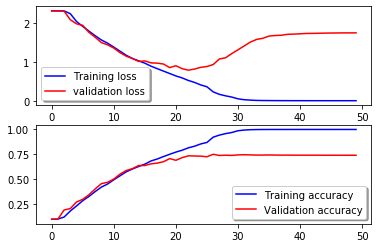

In [11]:
# 学習時/確認時の誤差関数および正解率を表示する。
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

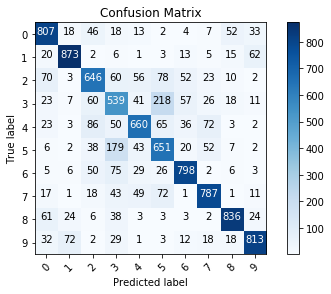

In [12]:
# Look at confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10)) 

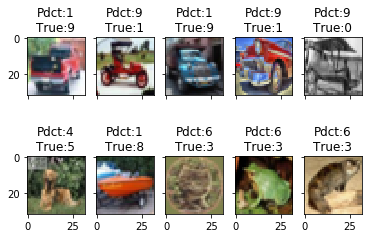

In [24]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Pdct:{}\nTrue:{}".format(pred_errors[error], obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Show the top 10 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

0. airplane(飛行機)
1. automobile(自動車)
2. bird(鳥)
3. cat(猫)
4. deer(鹿)
5. dog(犬)
6. frog(蛙)
7. horse(馬)
8. ship(船)
9. truck(トラック)